# Posterior Distributions
Andrew Esch, Evan Lee, and Collin Stratton

CST-425

Dr. Isac Artzi

2 April, 2022

# Introduction
The purpose of this assignment is to explore Markov Chain Monte Carlo (MCMC) by predicting the likelihood of people visiting a given attraction. This project will analyze and visualize the posterior distributions of the locations visited by tourists.

# Setup

In [19]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

from PosteriorDistributions import *

In [20]:
# read in data
df = pd.read_csv("./syntheticdata.csv", header=None)
# row and column headers list
headers = ["Museum", "Concert", "Sports Event", "Restaurant", "Hike"]

print(df)

   0  1  2  3  4
0  1  3  5  3  3
1  7  1  4  6  3
2  8  2  2  5  4
3  5  4  5  3  1
4  2  4  1  5  1


In [21]:
# Convert into a probabilistic matrix, and then convert the probabilistic matrix into a transition matrix
transitionMatrix = df.div(df.sum(axis=1), axis=0)
transitionMatrix = transitionMatrix.to_numpy()

print(transitionMatrixNP)

[[0.06666667 0.2        0.33333333 0.2        0.2       ]
 [0.33333333 0.04761905 0.19047619 0.28571429 0.14285714]
 [0.38095238 0.0952381  0.0952381  0.23809524 0.19047619]
 [0.27777778 0.22222222 0.27777778 0.16666667 0.05555556]
 [0.15384615 0.30769231 0.07692308 0.38461538 0.07692308]]


# Markov Chain
## Generate Steady State Distribution Graphs from the Transition Matrix using Markov Chains

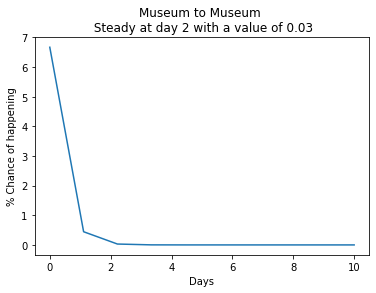

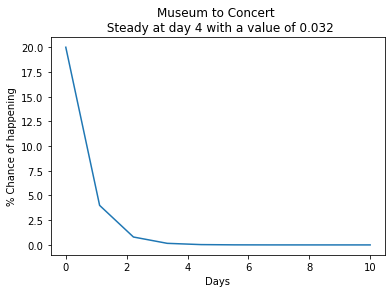

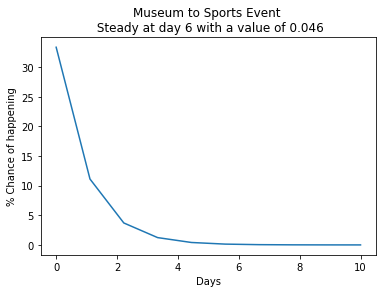

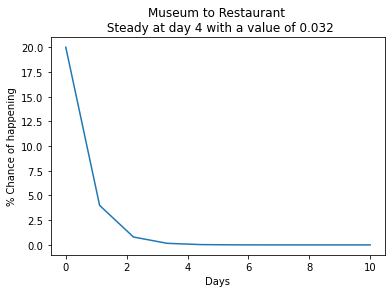

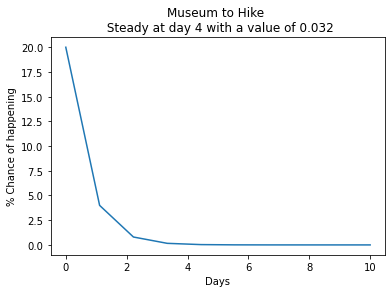

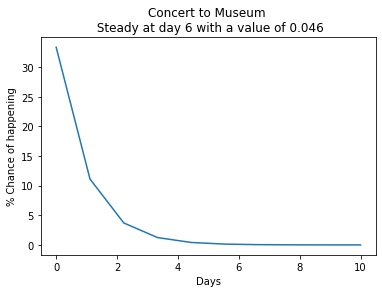

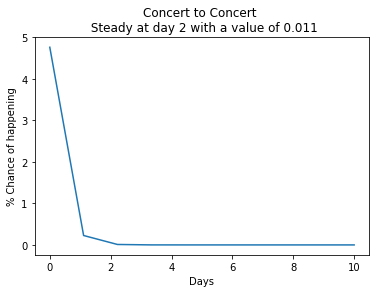

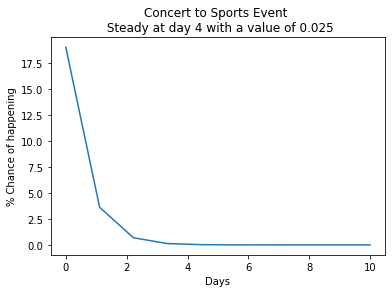

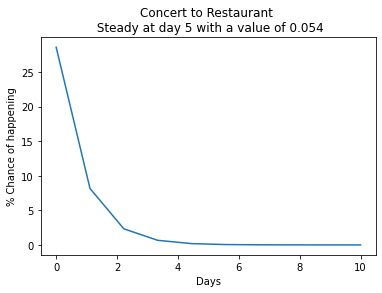

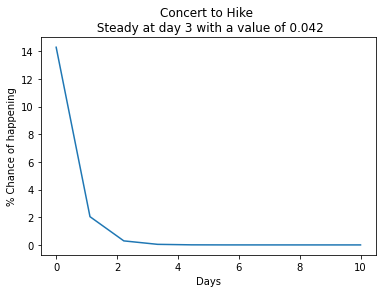

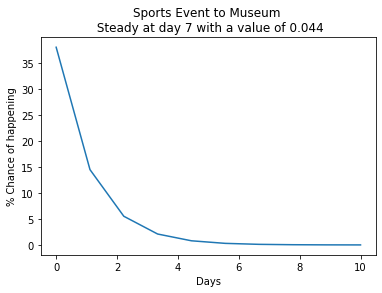

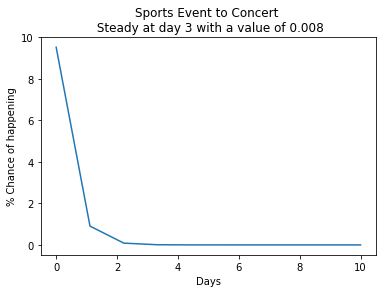

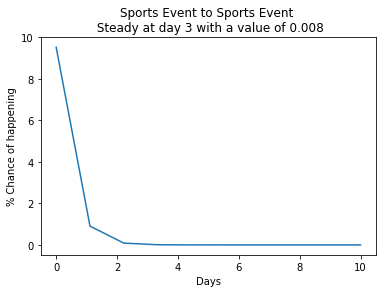

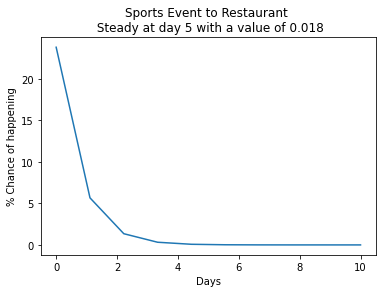

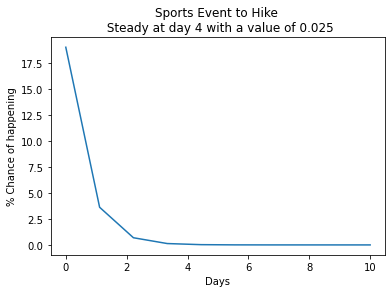

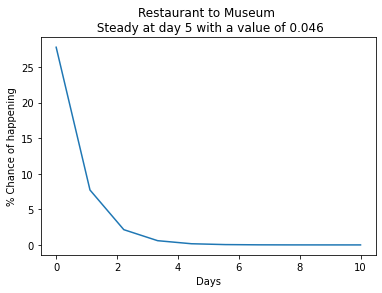

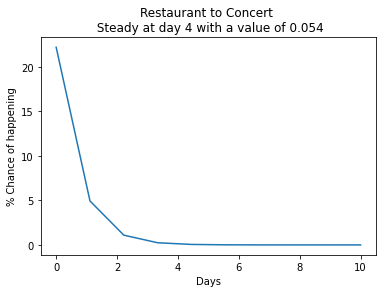

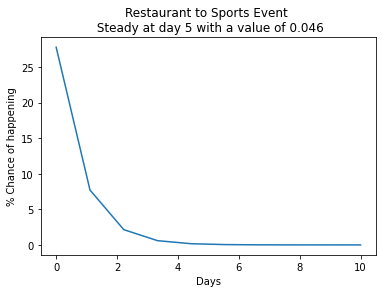

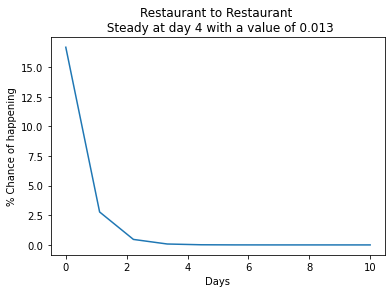

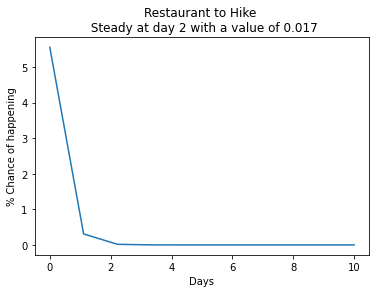

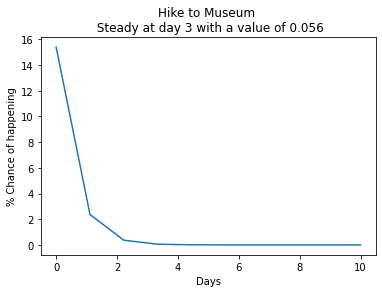

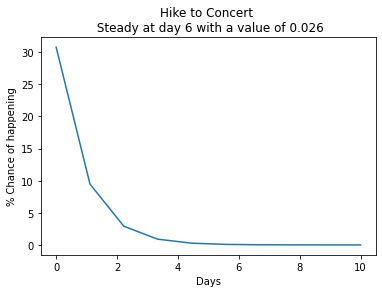

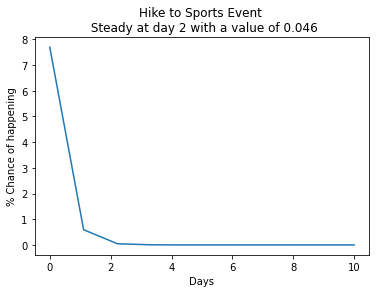

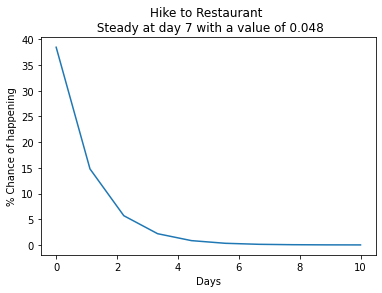

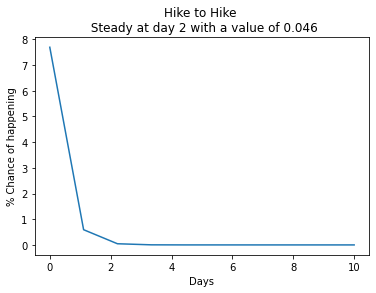

In [26]:
# Generate graphs from transition matrix to illustrate the Markov Chain
for i in range(transitionMatrix.shape[0]):
    for j in range(transitionMatrix.shape[1]):
        markovPlot(transitionMatrix, i, j, 11)

## Finding Probabilities
### Find the likelihood that a tourist would attend a concert, then go on a hike, then eat at a restaurant

In [23]:
# multiply the transition probability of concert to hike by hike to restaurant
concertHikeRestaurant = transitionMatrix[1][4] * transitionMatrix[4][3]
print("Percent odds of Concert to Hike to Restaurant = ", concertHikeRestaurant * 100)

Percent odds of Concert to Hike to Restaurant =  5.4945054945054945


### Find the likelihood of visiting any of the locations as the fifth step

In [24]:
# find the probabilities of the transition matrix on the 5th step
transDot = transitionMatrix
for i in range(4):  # Four transitions, so run 4 times
    transDot = np.dot(transDot, transitionMatrix)

# starting probability vector
spv = np.array([.2, .2, .2, .2, .2])

# sum the columns of the fifth step
sum_trans = transDot.sum(axis=0)

# multiply the starting probability vector by the sum of the columns
spv_tran = sum_trans * spv

# print the likelihood of visiting any of the locations as the fifth step
print("\nPercent odds of visiting the Museum 5th = ", spv_tran[0] * 100)
print("Percent odds of visiting the Concert 5th = ", spv_tran[1] * 100)
print("Percent odds of visiting the Sports Event 5th = ", spv_tran[2] * 100)
print("Percent odds of visiting the Restaurant 5th = ", spv_tran[3] * 100)
print("Percent odds of visiting the Hike 5th = ", spv_tran[4] * 100)


Percent odds of visiting the Museum 5th =  24.126087183341497
Percent odds of visiting the Concert 5th =  17.179216143611463
Percent odds of visiting the Sports Event 5th =  21.02655442956296
Percent odds of visiting the Restaurant 5th =  24.00018403603868
Percent odds of visiting the Hike 5th =  13.667958207445393


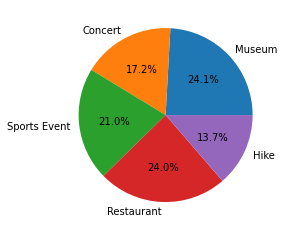

In [25]:
plt.pie(spv_tran, labels=headers, autopct='%1.1f%%')
plt.show()